# Ant Clony Optimization

In [38]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from functools import *
from itertools import *    # product
from pathlib import Path
from PIL import Image

plt.style.use('seaborn-whitegrid')

data_dir = Path('/kaggle/input/santa-2022')

In [39]:
df_image = pd.read_csv(data_dir / 'image.csv')

In [40]:
# Functions to map between cartesian coordinates and array indexes
def cartesian_to_array(x, y, shape):
    m, n = shape[:2]
    i = (n - 1) // 2 - y
    j = (n - 1) // 2 + x
    if i < 0 or i >= m or j < 0 or j >= n:
        raise ValueError("Coordinates not within given dimensions.")
    return i, j


def array_to_cartesian(i, j, shape):
    m, n = shape[:2]
    if i < 0 or i >= m or j < 0 or j >= n:
        raise ValueError("Coordinates not within given dimensions.")
    y = (n - 1) // 2 - i
    x = j - (n - 1) // 2
    return x, y


point = (1, 8)
shape = (9, 9, 3)
assert cartesian_to_array(*array_to_cartesian(*point, shape), shape) == point


# Functions to map an image between array and record formats
def image_to_dict(image):
    image = np.atleast_3d(image)
    kv_image = {}
    for i, j in product(range(len(image)), repeat=2):
        kv_image[array_to_cartesian(i, j, image.shape)] = tuple(image[i, j])
    return kv_image


def image_to_df(image):
    return pd.DataFrame(
        [(x, y, r, g, b) for (x, y), (r, g, b) in image_to_dict(image).items()],
        columns=['x', 'y', 'r', 'g', 'b']
    )


def df_to_image(df):
    side = int(len(df) ** 0.5)  # assumes a square image
    return df.set_index(['x', 'y']).to_numpy().reshape(side, side, -1)

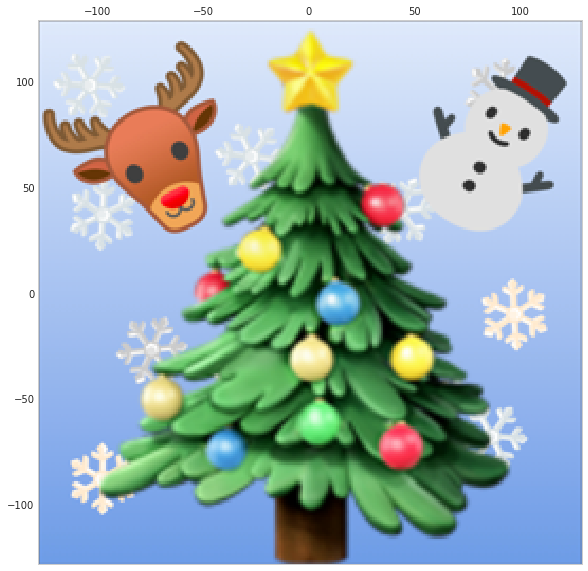

In [41]:
image = df_to_image(df_image)
assert image_to_df(image).equals(df_image)  # ensure transforms are inverses

radius = 128
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(image, extent=(-radius, radius+1, -radius, radius+1))
ax.grid(None);

In [42]:
def plot_configuration(config, image=None, ax=None, color='0.25', **figure_args):
    def get_position(config):
        return reduce(lambda p, q: (p[0] + q[0], p[1] + q[1]), config, (0, 0))

    if ax is None:
        _, ax = plt.subplots(**figure_args)

    k = 2 ** (len(config) - 1) + 1
    X, Y = (np.vstack([[(0, 0)], np.asarray(config).cumsum(axis=0)])[:-1].T - 0.5)
    U, V = np.asarray(config).T
    ax.quiver(
        X, Y, U, V,
        angles='xy', scale_units='xy', scale=1,
        color=color,
        width=0.005,
        zorder=10,
    )
    point = get_position(config)
    ax.plot(point[0]-0.5, point[1]-0.5, '.', color='k', zorder=11)
    if image is not None:
        ax.matshow(image, extent=[-k-1, k, -k-1, k])
    ax.set_xlim(-k-1, k)
    ax.set_ylim(-k-1, k)
    ax.set_aspect('equal')
    ax.set_xticks(np.arange(-k, k+1))
    ax.set_yticks(np.arange(-k, k+1))
    return ax

In [43]:
def get_position(config):
    return reduce(lambda p, q: (p[0] + q[0], p[1] + q[1]), config, (0, 0))


# The configuration of a 4-link arm descibed by a list of displacement vectors. 
config = [(4, 0), (-2, 2), (-1, 0), (-1, 1)]

get_position(config)

(0, 3)

In [44]:
def rotate_link(vector, direction):
    x, y = vector
    if direction == 1:  # counter-clockwise
        if y >= x and y > -x:
            x -= 1
        elif y > x and y <= -x:
            y -= 1
        elif y <= x and y < -x:
            x += 1
        else:
            y += 1
    elif direction == -1:  # clockwise
        if y > x and y >= -x:
            x += 1
        elif y >= x and y < -x:
            y += 1
        elif y < x and y <= -x:
            x -= 1
        else:
            y -= 1
    return (x, y)


def rotate(config, i, direction):
    config = config.copy()
    config[i] = rotate_link(config[i], direction)
    return config


def get_square(link_length):
    link = (link_length, 0)
    coords = [link]
    for _ in range(8 * link_length - 1):
        link = rotate_link(link, direction=1)
        coords.append(link)
    return coords

In [45]:
def get_neighbors(config):
    nhbrs = (
        reduce(lambda x, y: rotate(x, *y), enumerate(directions), config)
        for directions in product((-1, 0, 1), repeat=len(config))
    )
    return list(filter(lambda c: c != config, nhbrs))

In [46]:
config = [(4, 0), (-2, 2), (-1, 0), (-1, 1)]
neighbors = get_neighbors(config)

len(neighbors)

80

In [47]:
#neighbors

In [48]:
# Functions to compute the cost function

# Cost of reconfiguring the robotic arm: the square root of the number of links rotated
def reconfiguration_cost(from_config, to_config):
    nlinks = len(from_config)
    diffs = np.abs(np.asarray(from_config) - np.asarray(to_config)).sum(axis=1)
    return np.sqrt(diffs.sum())


# Cost of moving from one color to another: the sum of the absolute change in color components
def color_cost(from_position, to_position, image, color_scale=3.0):
    return np.abs(image[to_position] - image[from_position]).sum() * color_scale


# Total cost of one step: the reconfiguration cost plus the color cost
def step_cost(from_config, to_config, image):
    from_position = cartesian_to_array(*get_position(from_config), image.shape)
    to_position = cartesian_to_array(*get_position(to_config), image.shape)
    return (
        reconfiguration_cost(from_config, to_config) +
        color_cost(from_position, to_position, image)
    )

In [49]:
def get_direction(u, v):
    """Returns the sign of the angle from u to v."""
    direction = np.sign(np.cross(u, v))
    if direction == 0 and np.dot(u, v) < 0:
        direction = 1
    return direction


# We don't use this elsewhere, but you might find it useful."""
def get_angle(u, v):
    """Returns the angle (in degrees) from u to v."""
    return np.degrees(np.math.atan2(
        np.cross(u, v),
        np.dot(u, v),
    ))


def get_path_to_point(config, point):
    """Find a path of configurations to `point` starting at `config`."""
    path = [config]
    # Rotate each link, starting with the largest, until the point can
    # be reached by the remaining links. The last link must reach the
    # point itself.
    for i in range(len(config)):
        link = config[i]
        base = get_position(config[:i])
        relbase = (point[0] - base[0], point[1] - base[1])
        position = get_position(config[:i+1])
        relpos = (point[0] - position[0], point[1] - position[1])
        radius = reduce(lambda r, link: r + max(abs(link[0]), abs(link[1])), config[i+1:], 0)
        # Special case when next-to-last link lands on point.
        if radius == 1 and relpos == (0, 0):
            config = rotate(config, i, 1)
            if get_position(config) == point:  # Thanks @pgeiger
                path.append(config)
                break
            else:
                continue
        while np.max(np.abs(relpos)) > radius:
            direction = get_direction(link, relbase)
            config = rotate(config, i, direction)
            path.append(config)
            link = config[i]
            base = get_position(config[:i])
            relbase = (point[0] - base[0], point[1] - base[1])
            position = get_position(config[:i+1])
            relpos = (point[0] - position[0], point[1] - position[1])
            radius = reduce(lambda r, link: r + max(abs(link[0]), abs(link[1])), config[i+1:], 0)
    assert get_position(path[-1]) == point
    return path

In [50]:
def get_path_to_configuration(from_config, to_config):
    path = [from_config]
    config = from_config.copy()
    while config != to_config:
        for i in range(len(config)):
            config = rotate(config, i, get_direction(config[i], to_config[i]))
        path.append(config)
    assert path[-1] == to_config
    return path

In [51]:
# Compute total cost of path over image
def total_cost(path, image):
    return reduce(
        lambda cost, pair: cost + step_cost(pair[0], pair[1], image),
        zip(path[:-1], path[1:]),
        0,
    )


# total_cost(path, image)

In [52]:
def config_to_string(config):
    return ';'.join([' '.join(map(str, vector)) for vector in config])

### sample

In [53]:
from tqdm import tqdm

origin = [(64, 0), (-32, 0), (-16, 0), (-8, 0), (-4, 0), (-2, 0), (-1, 0), (-1, 0)]
n = origin[0][0] * 2
# points = list(product(range(-n, n + 1), repeat=2))
points = list(product(range(n, -n - 1, -1), repeat=2))
for i in range(len(points)):
    points[i] = (points[i][0], -points[i][1])

In [54]:
from tqdm import tqdm
path = [origin]
for p in tqdm(points):
    config = path[-1]
    path.extend(get_path_to_point(config, p)[1:])

# Now make sure we end at the "origin" configuration
path.extend(get_path_to_configuration(path[-1], origin)[1:])

len(path)

100%|██████████| 66049/66049 [00:12<00:00, 5172.56it/s]


133667

In [55]:
image = df_to_image(df_image)

total_cost(path, image)

166416.1289020252

In [56]:
#image

## Ant Clony Optimization

In [57]:
from scipy.sparse import dok_matrix
from math import inf
from tqdm.notebook import tqdm
from numba import jit, cuda, typed
import json

In [58]:
num_ant = 5    # 蚂蚁数量
alpha = 1       # 信息素重要程度因子
beta = 10        # 启发函数重要程度因子
rho = 0.1       # 信息素的挥发程度
Q = 1           # 完成度
itermax = 5   # 迭代次数
N = 257
NN = N * N

path_best = []
path_best_interval = 1
min_cost_each_iter = []


In [59]:
@jit(target_backend='cuda')
def hash_to_xy(i):
    return i//N, i%N

@jit(target_backend='cuda')
def xy_to_hash(x,y):
    return x*N+y

@jit(target_backend='cuda')
def get_cost(i, j):
    ix, iy = hash_to_xy(i)
    jx, jy = hash_to_xy(j)
    d = np.abs(ix-jx)+np.abs(iy-jy)
    return np.sum(np.abs(image[ix,iy]-image[jx,jy]))*3 + np.sqrt(d)

In [ ]:
def read_p():
    p_path = "/kaggle/input/santa-2022-ds-1/pheromone_mat.csv"
    p_df = pd.read_csv(p_path)
    p_mat = dok_matrix((NN, NN), dtype=np.float64)
    p_mat[p_df["x"].to_numpy(), p_df["y"].to_numpy()] = p_df["p"].to_numpy()
    return p_mat

In [60]:
# generate the cost map
eta_map = dok_matrix((NN, NN), dtype=np.float64)

for i in tqdm(range(NN)):
    x, y = hash_to_xy(i)
    for dx in range(-8, 9):
        for dy in range(-8, 9):
            nx, ny = x+dx, y+dy
            if np.abs(dx)+np.abs(dy) > 8:
                continue
            if nx<0 or N<=nx or ny<0 or N<=ny:
                continue
            j = xy_to_hash(nx, ny)
            if i == j:
                continue
            cost = get_cost(i, j)
            eta_map[i,j] = 1 / cost

  0%|          | 0/66049 [00:00<?, ?it/s]

In [ ]:
upload_p = True

In [61]:
if upload_p:
    pheromone_mat = read_p()
else:
    pheromone_mat = dok_matrix((NN, NN), dtype=np.float64)
    for i in tqdm(range(NN)):
        x, y = hash_to_xy(i)
        for dx in range(-8, 9):
            for dy in range(-8, 9):
                nx, ny = x+dx, y+dy
                if np.abs(dx)+np.abs(dy) > 8:
                    continue
                if nx<0 or N<=nx or ny<0 or N<=ny:
                    continue
                j = xy_to_hash(nx, ny)
                if i == j:
                    continue
                pheromone_mat[i,j] = 1

  0%|          | 0/66049 [00:00<?, ?it/s]

In [62]:
def get_total_cost(path_ant):
    points = []
    path_ant = path_ant[1:]
    for i in path_ant:
        x, y = hash_to_xy(i)
        points.append((y - 128, 128 - x))
    path = [origin]
    for p in points:
        config = path[-1]
        path.extend(get_path_to_point(config, p)[1:])

    # Now make sure we end at the "origin" configuration
    path.extend(get_path_to_configuration(path[-1], origin)[1:])
    return total_cost(path, image)

In [63]:
# !nvidia-smi

Mon Dec 26 19:11:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [103]:
@jit(target_backend='cuda')
def init_no_visit(num_ant):
    nv = list(range(NN))
    nv.remove(33024)
    return [nv for i in range(num_ant)]


@jit(target_backend='cuda')
def get_around_cells(t, now_place, ant_visit, ant_no_visit):
    x, y = hash_to_xy(now_place)
    around_cells = []
    for dx in range(-8, 9):
        for dy in range(-8, 9):
            nx, ny = x+dx, y+dy
            if np.abs(dx)+np.abs(dy) > 8:
                continue
            if nx<0 or N<=nx or ny<0 or N<=ny:
                continue
            around_cell = xy_to_hash(nx, ny)
            if now_place == around_cell:
                continue
            if t <= NN / 2 and around_cell in ant_visit:
                continue
            if t > NN / 2 and around_cell not in ant_no_visit:
                continue
            around_cells.append(around_cell)
    return around_cells

@jit(target_backend='cuda')
def get_next_cell(around_cells, around_tau, around_eta):
    around_prob = np.power(around_tau, alpha) * np.power(around_eta, beta)
    around_prob /= around_prob.sum()
    around_prob = around_prob.cumsum()

    rand_choice = np.random.rand()
    next_cell = around_cells[0]
    for i in range(len(around_prob)):
        if around_prob[i] > rand_choice:
            next_cell = around_cells[i]
            break

    return next_cell

@jit(target_backend='cuda')
def get_near_next_cell(now_p, ant_nv):
    nv_x = ant_nv // N
    nv_y = ant_nv % N
    nv_d = np.power(nv_x - now_p // N, 2) + np.power(nv_y - now_p % N, 2)
    return ant_nv[np.argmin(nv_d)]

In [65]:
np.random.seed(2021)

In [98]:
def download_p(p_mat):
    lp = p_mat.nonzero()
    p_pd = pd.DataFrame(data={"x": lp[0], "y": lp[1], "p": np.ravel(p_mat[lp])})
    p_pd.to_csv('pheromone_mat.csv', index=False)

In [67]:
def ACO_run(p_mat, itermax=100, num_ant=20):
    bar_iter = tqdm(total=itermax, desc = "iter", position=0, leave=None)
    bar_ant = tqdm(total=num_ant, desc = "ant", position=1, leave=None)
    bar_cell = tqdm(total=NN-1, desc = "cell", position=2, leave=None)
    bar_cost = tqdm(total=num_ant, desc = "cost", position=3, leave=None)
    bar_update = tqdm(total=num_ant, desc = "update", position=4, leave=None)



    for t in range(itermax):
        path_cache = [[33024] for i in range(num_ant)]
        no_visit = init_no_visit(num_ant)
        cost_cache = []
        pheromone_cache = dok_matrix((NN, NN), dtype=np.float64)

        bar_ant.reset()
        bar_cost.reset()
        bar_update.reset()

        for ant in range(num_ant):
            bar_cell.reset()
            ant_visit = path_cache[ant]
            ant_no_visit = no_visit[ant]
            for color_cell in range(NN-1):
                now_place = ant_visit[-1]

                # search around
                around_cells = get_around_cells(t, now_place, np.array(ant_visit), np.array(ant_no_visit))
                around_tau = [p_mat[now_place, i] for i in around_cells]
                around_eta = [eta_map[now_place, i] for i in around_cells]

                if len(around_cells):
                    next_cell = get_next_cell(typed.List(around_cells),
                                              np.array(around_tau), 
                                              np.array(around_eta))
                else:
                    next_cell = get_near_next_cell(now_place, np.array(ant_no_visit))
                    next_cell = int(next_cell)

                ant_visit.append(next_cell)
                ant_no_visit.remove(next_cell)

                bar_cell.update(1)

            bar_ant.update(1)

        min_index = -1
        min_value = inf
        for ant in range(num_ant):
            ant_cost = get_total_cost(path_cache[ant])
            cost_cache.append(ant_cost)
            if ant_cost < min_value:
                min_value = ant_cost
                min_index = ant
            bar_cost.update(1)



        min_cost_each_iter.append(min_value)

        if (t + 1) % path_best_interval == 0:
            path_best.append(path_cache[min_index])
            print(f"iter {t}\t\tmin cost: {min_value}")

        # update pheromone_mat
        for ant in range(num_ant):
            ant_cost = cost_cache[ant] / min_value
            ant_visit = path_cache[ant]
            for visit_path in range(NN - 1):
                p_begin = ant_visit[visit_path]
                p_end = ant_visit[visit_path + 1]
                pheromone_cache[p_begin, p_end] += Q / ant_cost * eta_map[p_begin,p_end]
            bar_update.update(1)

        p_mat = p_mat.multiply(1 - rho) + pheromone_cache

        bar_iter.update(1)
        
    return p_mat

In [68]:
pheromone_mat = ACO_run(pheromone_mat, itermax, num_ant)

iter:   0%|          | 0/5 [00:00<?, ?it/s]

ant:   0%|          | 0/5 [00:00<?, ?it/s]

cell:   0%|          | 0/66048 [00:00<?, ?it/s]

cost:   0%|          | 0/5 [00:00<?, ?it/s]

update:   0%|          | 0/5 [00:00<?, ?it/s]

iter 0		min cost: 155220.0208684964
iter 1		min cost: 146806.26752534282
iter 2		min cost: 143157.15930562242
iter 3		min cost: 142975.12723816274
iter 4		min cost: 141427.8379605015


In [69]:
points = []
path_ant = path_best[0][1:]
for i in path_ant:
    x, y = hash_to_xy(i)
    points.append((y - 128, 128 - x))
path = [origin]
for p in points:
    config = path[-1]
    path.extend(get_path_to_point(config, p)[1:])

# Now make sure we end at the "origin" configuration
path.extend(get_path_to_configuration(path[-1], origin)[1:])

In [99]:
download_p(pheromone_mat)

In [105]:
cost_df = pd.DataFrame({"min cost": min_cost_each_iter})
cost_df.to_csv("min cost.csv", index=False)

In [100]:
total_cost(path, image)

155220.0208684964

In [101]:
submission = pd.Series(
    [config_to_string(config) for config in path],
    name="configuration",
)

submission.head()

0      64 0;-32 0;-16 0;-8 0;-4 0;-2 0;-1 0;-1 0
1     64 0;-32 0;-16 0;-8 0;-4 0;-2 0;-1 0;-1 -1
2    64 -1;-32 0;-16 0;-8 0;-4 0;-2 0;-1 0;-1 -1
3    64 -2;-32 0;-16 0;-8 0;-4 0;-2 0;-1 0;-1 -1
4    64 -3;-32 0;-16 0;-8 0;-4 0;-2 0;-1 0;-1 -1
Name: configuration, dtype: object

In [102]:
submission.to_csv('submission.csv', index=False)

In [111]:
!mkdir -p ~/.kaggle
!cp /kaggle/input/kaggle-json/kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [115]:
# !kaggle datasets init -p /kaggle/working/

Data package template written to: /kaggle/working/dataset-metadata.json


In [128]:
# Data to be written
dataset_dict = {
    "title": "santa-2022-ds-2",
    "id": 'hekaibu/santa-2022-ds-2',
    "licenses": [{'name': 'CC0-1.0'}]
}
 
with open("dataset-metadata.json", "w") as outfile:
    json.dump(dataset_dict, outfile)

In [130]:
!kaggle datasets create -p /kaggle/working/

Starting upload for file __notebook_source__.ipynb
100%|████████████████████████████████████████████| 263/263 [00:01<00:00, 156B/s]
Upload successful: __notebook_source__.ipynb (263B)
Starting upload for file submission.csv
100%|██████████████████████████████████████| 5.45M/5.45M [00:02<00:00, 2.01MB/s]
Upload successful: submission.csv (5MB)
Starting upload for file pheromone_mat.csv
100%|████████████████████████████████████████| 272M/272M [00:09<00:00, 29.2MB/s]
Upload successful: pheromone_mat.csv (272MB)
Starting upload for file min cost.csv
100%|███████████████████████████████████████████| 102/102 [00:02<00:00, 49.5B/s]
Upload successful: min cost.csv (102B)
Skipping folder: .virtual_documents; use '--dir-mode' to upload folders
Your private Dataset is being created. Please check progress at https://www.kaggle.com/datasets/hekaibu/santa-2022-ds-1
